<a href="https://colab.research.google.com/github/IntroComputationalPhysics-UNT/kapitza-pendulum-Mattmflores/blob/main/kapitza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# import modules
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

## Dimenionless equation of motion


$$
\theta'' + 2\zeta\,\theta' + \left(\epsilon^2 - \alpha\cos\tau\right)\sin\theta = 0,
$$

- primes denote derivatives with respect to dimensionless time $\tau$.

To use `solve_ivp`, convert system to first-order form.  
Define the vector

$$
y =
\begin{bmatrix}
\theta \\
\theta'
\end{bmatrix}.
$$

Then

$$
\begin{aligned}
\theta' &= \omega, \\
\omega' &= -2\zeta\,\omega - \left(\epsilon^2 - \alpha\cos\tau\right)\sin\theta.
\end{aligned}
$$


In [10]:
# Function: kapitza_rhs
# Parameters:
#     tau(float)           : dimensionless time
#     y(ndarray)           : state variables [theta, theta_prime]
#     epsilon(float)       : dimensionless frequency
#     alpha(float)         : drive amplitude, alpha = y_0 / l
#     zeta(float)          : dimensionless damping coefficient
# Returns:
#     dydtau(ndarray)      : time derivatives [theta_prime, theta_double_prime]
# Description:
#     Defines the equation of motion for the Kapitza pendulum.
def kapitza_rhs(tau, y, epsilon, alpha, zeta):
    theta, theta_prime = y
    dtheta_dtau = theta_prime
    d2theta_dtau2 = -2.0 * zeta * theta_prime - (epsilon**2 - alpha * np.cos(tau)) * np.sin(theta)
    dydtau = np.array([dtheta_dtau, d2theta_dtau2])
    return dydtau


## Basic plotting and angle wrapping

Define an angle wrapping helper to measure how far the pendulum is from the inverted state

### Pseudocode: angle_mod

1. Input: angle `phi`
2. Shift by +π
3. Reduce modulo 2π
4. Shift back by −π
5. Output in the range (-π, π]


In [11]:
# Function: angle_mod
# Parameters:
#   phi(float or ndarray) : input angles in radians
# Returns:
#   wrapped_phi(float or ndarray) : angles mapped into the interval (-pi, pi]
# Description:
#   Wraps an angle so that it lies in the range (-pi, pi]
def angle_mod(phi):
    return (phi + np.pi) % (2.0 * np.pi) - np.pi

In [12]:
# Function: basic_plot
# Parameters:
#   t(float or ndarray)  : dimensionless time array
#   y(float or ndarray)  : data values to plot versus t
#   xlabel(str, optional): x-axis label
#   ylabel(str, optional): y-axis label
#   figsize(tuple)       : figure size in inches
# Returns:
#   None
# Description:
#   Creates a time-series plot of y versus t
def basic_plot(t, y, xlabel=None, ylabel=None, figsize=(3,3)):
    plt.figure(figsize=figsize)
    plt.plot(t, y)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Numerical strategy

Determine whether the inverted state ($\theta \approx \pi$, $\theta' \approx 0$) is stable for a given set of parameters $(\epsilon, \alpha, \zeta)$.

Set:

- Initial conditions close to the inverted state:
  - $\theta_0 = \pi + \delta\theta_0$, with small $\delta\theta_0$
  - $\theta'_0 = 0$
- Drive period in dimensionless time:
  - forcing term is $\cos\tau$; therefore, the period is $T = 2\pi$ in $\tau$
- Integrate for many drive periods:
  - Total periods: $N_\text{total}$
  - Discard the first $N_\text{trans}$ periods as transient
  - Use the remaining periods

### RMS distance from the inverted state

1. After discarding transients, compute the wrapped deviation  
   $\delta\theta(\tau) = \text{angle_mod}\big(\theta(\tau) - \pi\big)$.
2. Compute root-mean-square (RMS):  
   $\Delta_\text{RMS} = \sqrt{\langle \delta\theta^2 \rangle}$
3. If $\Delta_\text{RMS}$ is small, call the inverted state *stable*; otherwise call it *unstable*



In [13]:
# Function: integrate_kapitza
# Parameters:
#     epsilon(float)       : dimensionless frequency
#     alpha(float)         : drive amplitude
#     zeta(float)          : damping coefficient
#     theta0(float)        : initial angle
#     theta_prime0(float)  : initial angular velocity
#     n_periods_total(int) : total number of drive periods to integrate
#     n_periods_trans(int) : number of periods to discard as transient
#     n_points_per_period(int): sampling resolution per period
# Returns:
#     tau_sample(ndarray)  : time values after transient
#     theta_sample(ndarray): angle values after transient
#     rms_deviation(float) : RMS deviation from theta = pi
# Description:
#     Integrates the Kapitza pendulum for given parameters and computes
#     long-time stability.
def integrate_kapitza(epsilon, alpha, zeta,
                      theta0=np.pi + 0.05, theta_prime0=0.0,
                      n_periods_total=300, n_periods_trans=100,
                      n_points_per_period=50):

    # period in dimensionless time
    T = 2.0 * np.pi

    # total integration time
    tau_max = n_periods_total * T
    tau_span = (0.0, tau_max)

    # time evaluation grid
    n_points_total = n_periods_total * n_points_per_period
    tau_eval = np.linspace(0.0, tau_max, n_points_total)

    # initial state vector
    y0 = np.array([theta0, theta_prime0])

    # solve the IVP
    sol = solve_ivp(
        kapitza_rhs,
        tau_span,
        y0,
        args=(epsilon, alpha, zeta),
        t_eval=tau_eval,
        method="Radau"
    )

    # extract theta(tau)
    theta = sol.y[0, :]
    tau = sol.t

    # discard transient: keep times after n_periods_trans
    tau_trans_end = n_periods_trans * T
    mask = tau >= tau_trans_end

    tau_sample = tau[mask]
    theta_sample = theta[mask]

    # compute deviation from inverted state
    dtheta = angle_mod(theta_sample - np.pi)

    # RMS deviation
    rms_deviation = np.sqrt(np.mean(dtheta**2))

    return tau_sample, theta_sample, rms_deviation


## Parameter sweep over (ε, α)

Scan over grid for a fixed damping

- Choose 2D grid:
  - ε values = x-axis,
  - α values = y-axis.
- For each pair (ε, α):
  1. Integrate,
  2. Compute the RMS deviation from the inverted state,
  3. Store the result in an array.

Will use this map to:

- Visualize long-time response,
- Define a simple threshold to classify “stable” vs “unstable”.


In [14]:
# Function: parameter_sweep
# Parameters:
#     epsilon_values(ndarray) : 1D array of epsilon values
#     alpha_values(ndarray)   : 1D array of alpha values
#     zeta(float)             : damping coefficient
#     kwargs                  : forwarded to integrate_kapitza
# Returns:
#     rms_map(ndarray)        : 2D array of RMS deviations
# Description:
#     Sweeps over a grid of (epsilon, alpha) and computes the long-time
#     stability at each point.
def parameter_sweep(epsilon_values, alpha_values, zeta, **kwargs):
    n_eps = len(epsilon_values)
    n_alp = len(alpha_values)
    rms_map = np.zeros((n_alp, n_eps))

    for j, alpha in enumerate(alpha_values):
        for i, epsilon in enumerate(epsilon_values):
            _, _, rms_dev = integrate_kapitza(epsilon, alpha, zeta, **kwargs)
            rms_map[j, i] = rms_dev
    return rms_map


# Choose grid and run sweep *takes a while
zeta_fixed = 0.1
epsilon_values = np.linspace(0.5, 3.0, 25)   # x-axis
alpha_values   = np.linspace(0.0, 6.0, 31)   # y-axis

rms_map = parameter_sweep(
    epsilon_values, alpha_values, zeta_fixed,
    theta0=np.pi + 0.05,
    theta_prime0=0.0,
    n_periods_total=200,
    n_periods_trans=70,
    n_points_per_period=40
)


## Guessing a stability boundary

Based on the Kapitza analysis, the critical drive amplitude should scale as

$$
\alpha_c(\epsilon) \propto \epsilon^2,
$$

for large epsilon and small damping.

Assumed form of solution

$$
\alpha_c(\epsilon) = C\,\epsilon^2,
$$

with a constant \(C\) = 0.7 chosen from map; therefore,

$$
\alpha_c(\epsilon) = 0.7\,\epsilon^2
$$

Encapsulate in  `alpha_critical`.



In [15]:
# Function: alpha_critical
# Parameters:
#     epsilon(float or ndarray) : dimensionless frequency
#     zeta(float)               : damping coefficient
#     coef(float)               : proportionality constant C
# Returns:
#     alpha(float or ndarray)   : critical alpha values
# Description:
#     Defines the guessed stability boundary alpha_c(epsilon).
def alpha_critical(epsilon, zeta, coef=2.0):
    alpha_c = coef * epsilon**2
    return alpha_c


## 2D stability plot with boundary overlay

1. Plot the RMS deviation map `rms_map` as an image with:
   - ε = x-axis,
   - α = y-axis,
   - color indicating the RMS deviation.
2. Overlay guessed curve
3. Tune `coef` and the threshold so that the curve follows
the interface between “small RMS” and “large RMS”


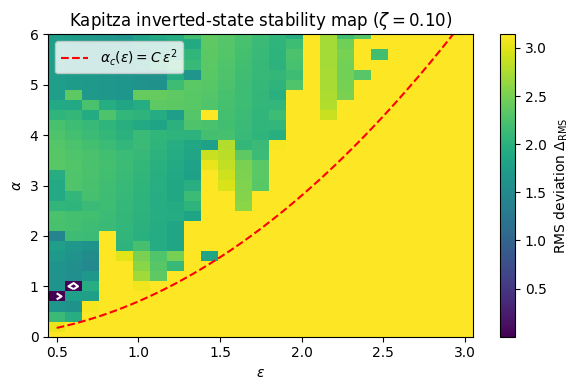

In [16]:
# Choose stability threshold for RMS deviation:
#   small RMS < threshold  -> "stable inverted"
#   large RMS > threshold  -> "unstable inverted"
stability_threshold = 0.5

# Create 2D plot
plt.figure(figsize=(6, 4))

# Use pcolormesh to show RMS deviations
Eps, Alp = np.meshgrid(epsilon_values, alpha_values)

c = plt.pcolormesh(Eps, Alp, rms_map,
                   shading='auto')
plt.colorbar(c, label=r'RMS deviation $\Delta_{\rm RMS}$')

# Contour for stability threshold
cs = plt.contour(Eps, Alp, rms_map,
                 levels=[stability_threshold],
                 colors='white',
                 linewidths=1.5)
plt.clabel(cs, fmt={stability_threshold: r'$\Delta_{\rm RMS} = %.2f$' % stability_threshold},
           inline=True, fontsize=8)

# Overlay guessed boundary alpha_c(epsilon)
eps_dense = np.linspace(epsilon_values.min(), epsilon_values.max(), 200)
alpha_guess = alpha_critical(eps_dense, zeta_fixed, coef=0.7) # coef can be adjusted

plt.plot(eps_dense, alpha_guess, 'r--', label=r'$\alpha_c(\epsilon) = C\,\epsilon^2$')

plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\alpha$')
plt.title(r'Kapitza inverted-state stability map ($\zeta = %.2f$)' % zeta_fixed)
plt.legend(loc='upper left')
plt.ylim(alpha_values.min(), alpha_values.max())
plt.tight_layout()
plt.show()



## Summary

This stability analysis uses the long-time RMS deviation of the shifted angle  
$\delta\theta(\tau) = \text{angle\_mod}(\theta(\tau) - \pi)$  
as the diagnostic for whether the inverted state is stable. Small RMS values correspond to trajectories that remain
close to the inverted position, while larger values indicate loss of stability.

The numerical parameters were chosen to balance computation and accuracy.
The system is integrated over a long time interval to
allow transients to decay. The time step corresponds to a fixed number of
samples per drive period. The $(\epsilon,\alpha)$ grid was selected to cover the
parameter range where stabilization is expected, while keeping the sweep
computationally reasonable.

For the stability boundary,
$\alpha_c(\epsilon) = C\,\epsilon^2$ was used. This was based on the Kapitza
high-frequency analysis in which the stabilizing term is proportional with
$\epsilon^2$. The constant $C$ was chosen by eye so that the curve
follows the transition region in the map. The fit
captures the trendline of the boundary well, with slight deviations
near the edges of the parameter range.
